In [1]:
import gym, torch, random, copy, time
import matplotlib.pyplot as plt
from collections import deque
import keras

Using TensorFlow backend.


In [53]:
D_in = 4
H1 = 50
D_out = 2
batch_size = 1
lr = 0.004

layer_1 = torch.nn.Linear(D_in, H1)
layer_2 = torch.nn.Linear(H1, D_out)
layer_1.weight.data.fill_(0)
layer_2.weight.data.fill_(0)

model = torch.nn.Sequential(
    layer_1,
    torch.nn.ReLU(),
    layer_2
)

loss_fn = torch.nn.MSELoss(reduction="sum")

optim = torch.optim.Adam(model.parameters(), lr=lr)

0 200.0
33.50225615501404


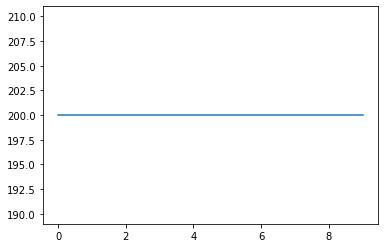

In [71]:
start_time = time.time()
env = gym.make('CartPole-v0')
gamma = 0.9
epsilon = 0.1
epsilon_decay = 1
reward_arr = []
cum_reward = 0
for _ in range(10):
    
    current_state = env.reset()
    episode_reward = 0
    done = False
    
    while not done:
        current_state = torch.FloatTensor(current_state)
        y_pred = model(current_state)
        
        env.render()
        
        if random.random()<epsilon:
            action = env.action_space.sample()
        else:
            action = torch.argmax(y_pred).item()
        
        next_state, reward, done, info = env.step(action)
        
        episode_reward += reward
        cum_reward+=reward
        
        current_state = next_state
        if done:
            break
        continue
        
        if done:
            target_array = y_pred.tolist()
            target_array[action] = -100
            target_tensor = torch.FloatTensor(target_array)

            #print(action, y_pred.tolist(), target_tensor.tolist())
            loss = loss_fn(y_pred, target_tensor)

            optim.zero_grad()
            loss.backward()
            optim.step()
            break
        else:
            target_array = y_pred.tolist()
            with torch.no_grad():
                target_array[action] = reward + gamma*torch.max(model(torch.FloatTensor(next_state))).item()
            target_tensor = torch.FloatTensor(target_array)

            #print(action, y_pred.tolist(), target_tensor.tolist())
            loss = loss_fn(y_pred, target_tensor)

            optim.zero_grad()
            loss.backward()
            optim.step()

            current_state = next_state
            

    reward_arr.append(episode_reward)
    epsilon *= epsilon_decay
        
    if _%100==0:
        print(_, cum_reward/(_+1))
env.close()
plt.plot(reward_arr)
print(time.time()-start_time)

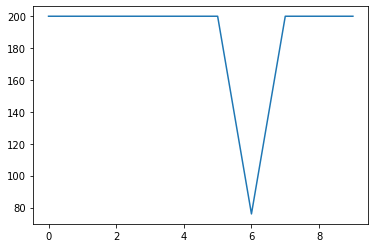

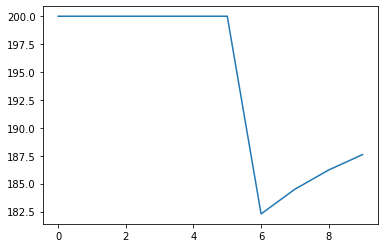

In [62]:
plt.plot(reward_arr)
plt.show()

running_avg = []
val = 0

for i in range(len(reward_arr)):
    val += reward_arr[i]
    running_avg.append(val/(i+1))
plt.plot(running_avg)
plt.show()

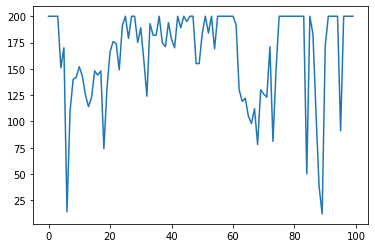

In [57]:
plt.plot(reward_arr[-100:])
plt.show()

In [58]:
sum(reward_arr[-100:])/100

163.76

In [63]:
torch.save(model, "best_1_-100.model")

In [13]:
env.observation_space.shape[0]

4

In [6]:
class DQNAgent():
    
    def __init__(self, env, hidden_layer = 50, batch_size = 128, lr = 0.005, e=0.2, gamma=0.9):
        self.env = env
        layer_1 = torch.nn.Linear(env.observation_space.shape[0], hidden_layer)
        layer_2 = torch.nn.Linear(hidden_layer, env.action_space.n)
        layer_1.weight.data.fill_(0)
        layer_2.weight.data.fill_(0)

        self.model = torch.nn.Sequential(
            layer_1,
            torch.nn.ReLU(),
            layer_2
        )
        self.loss_fn = torch.nn.MSELoss(reduction="sum")
        self.optim = torch.optim.Adam(model.parameters(), lr=lr)
        
        self.mem = []
        self.batch_size = batch_size
        
        self.e = e
        self.gamma = gamma
    
    def q_val(self, state):
        return self.model(state)

    def save_transition(self, state, reward, action, done, next_state):
        self.mem.append((state, reward, action, done, next_state))
        
    def train(self):
        if len(self.mem)>=self.batch_size:
            while len(self.mem)!=0:
                state, reward, action, done, next_state = self.mem.pop()
                
                y_pred = self.model(torch.FloatTensor(state))
                
                y_target = y_pred.tolist()
                if done:
                    y_target[action] = reward
                else:
                    with torch.no_grad():
                        y_target[action] = reward+self.gamma*torch.max(self.model(torch.FloatTensor(next_state))).item()
                y_target_tensor = torch.FloatTensor(y_target)
                
                loss = self.loss_fn(y_pred, y_target_tensor)

                optim.zero_grad()
                loss.backward()
                optim.step()
    
    def act(self, state):
        state = torch.FloatTensor(state)
        if random.random()<self.e:
            return self.env.action_space.sample()
        return torch.argmax(self.q_val(state)).item()

Failed to complete in trial 0


KeyboardInterrupt: 